In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina' # I use a HiDPI screen

In [2]:
from fishchips.experiments import CMB_Primary
from fishchips.cosmo import Observables
import fishchips.cmb_lensing
import fishchips.util

from classy import Class  # CLASS python wrapper
import numpy as np
import matplotlib.pyplot as plt
default_color_list = ['#1A1A1A', '#0072B2', '#009E73', '#D55E00', '#CC79A7', '#F0E442', '#56B4E9']

In [15]:
# create an Observables object to store information for derivatives
pars = np.array( ['omega_b', 'omega_cdm', 'h',  'A_s', 'n_s', 'tau_reio', 'sum_mnu'])
centers = np.array([0.02222,  0.1197,  0.69,  2.1955e-9, 0.9655, 0.06, 0.06])
left_steps = np.array([0.0008, 0.003,   0.02,   0.1e-9, 0.01, 0.02, 0.0])
right_steps = np.array([0.0008, 0.003,   0.02,   0.1e-9, 0.01, 0.02, 0.02])

obs = Observables(parameters=pars,
                  fiducial=centers,
                  left=centers-left_steps,
                  right=centers+right_steps)

# generate a template CLASS python wrapper configuration
classy_template = {'output': 'tCl pCl lCl mPk',
                   'l_max_scalars': 5000,
                   'lensing': 'yes',
                   
                 'reionization_optical_depth_tol': 1e-07,
                 'tol_background_integration': 1e-8,
                 'tol_perturb_integration': 1e-8,
                 'tol_thermo_integration': 1e-8,
              
                 'perturb_sampling_stepsize':0.01,
                 'k_max_tau0_over_l_max' : 6,
                   
                  'P_k_max_1/Mpc':3.0}
# classy_template.update(fishchips.util.PRECISE_CLASS_DICT)

# add in the fiducial values too
classy_template.update(dict(zip(obs.parameters, obs.fiducial)))

In [16]:
# generate the fiducial cosmology
obs.compute_cosmo(key='CLASS_fiducial',
                  classy_dict=fishchips.util.neutrino_dict(classy_template))

# generate an observables dictionary, looping over parameters
for par, par_left, par_right in zip(obs.parameters, obs.left, obs.right):
    classy_left = classy_template.copy()
    classy_left[par] = par_left
    classy_right = classy_template.copy()
    classy_right[par] = par_right
    # pass the dictionaries full of configurations to get computed
    obs.compute_cosmo(key=par + '_CLASS_left',
                      classy_dict=fishchips.util.neutrino_dict(classy_left))
    obs.compute_cosmo(key=par + '_CLASS_right',
                      classy_dict=fishchips.util.neutrino_dict(classy_right))

In [17]:
Allison_Planck = [fishchips.experiments.CMB_Primary(l_min=2, 
                                                l_max=2500, f_sky=0.44),
                     fishchips.cmb_lensing.CMB_Lensing_Only(lens_kmax=2000, 
                                                            lens_tellmax=2500, 
                                                            lens_pellmax=2500, 
                                                            lens_f_sky=0.44)]

Generating theory Cls...
Loaded cached Cls from  output/clsAll_low_acc_False_3500_20180822.pkl
Loaded cached Cls from  output/clphi_low_acc_False_3500_20180822.txt



generating new axis
['$\\mathrm{omega\\_b}$', '$\\mathrm{omega\\_cdm}$', '$\\mathrm{h}$', '$\\mathrm{A\\_s}$', '$\\mathrm{n\\_s}$', '$\\mathrm{tau\\_reio}$', '$\\mathrm{sum\\_mnu}$']


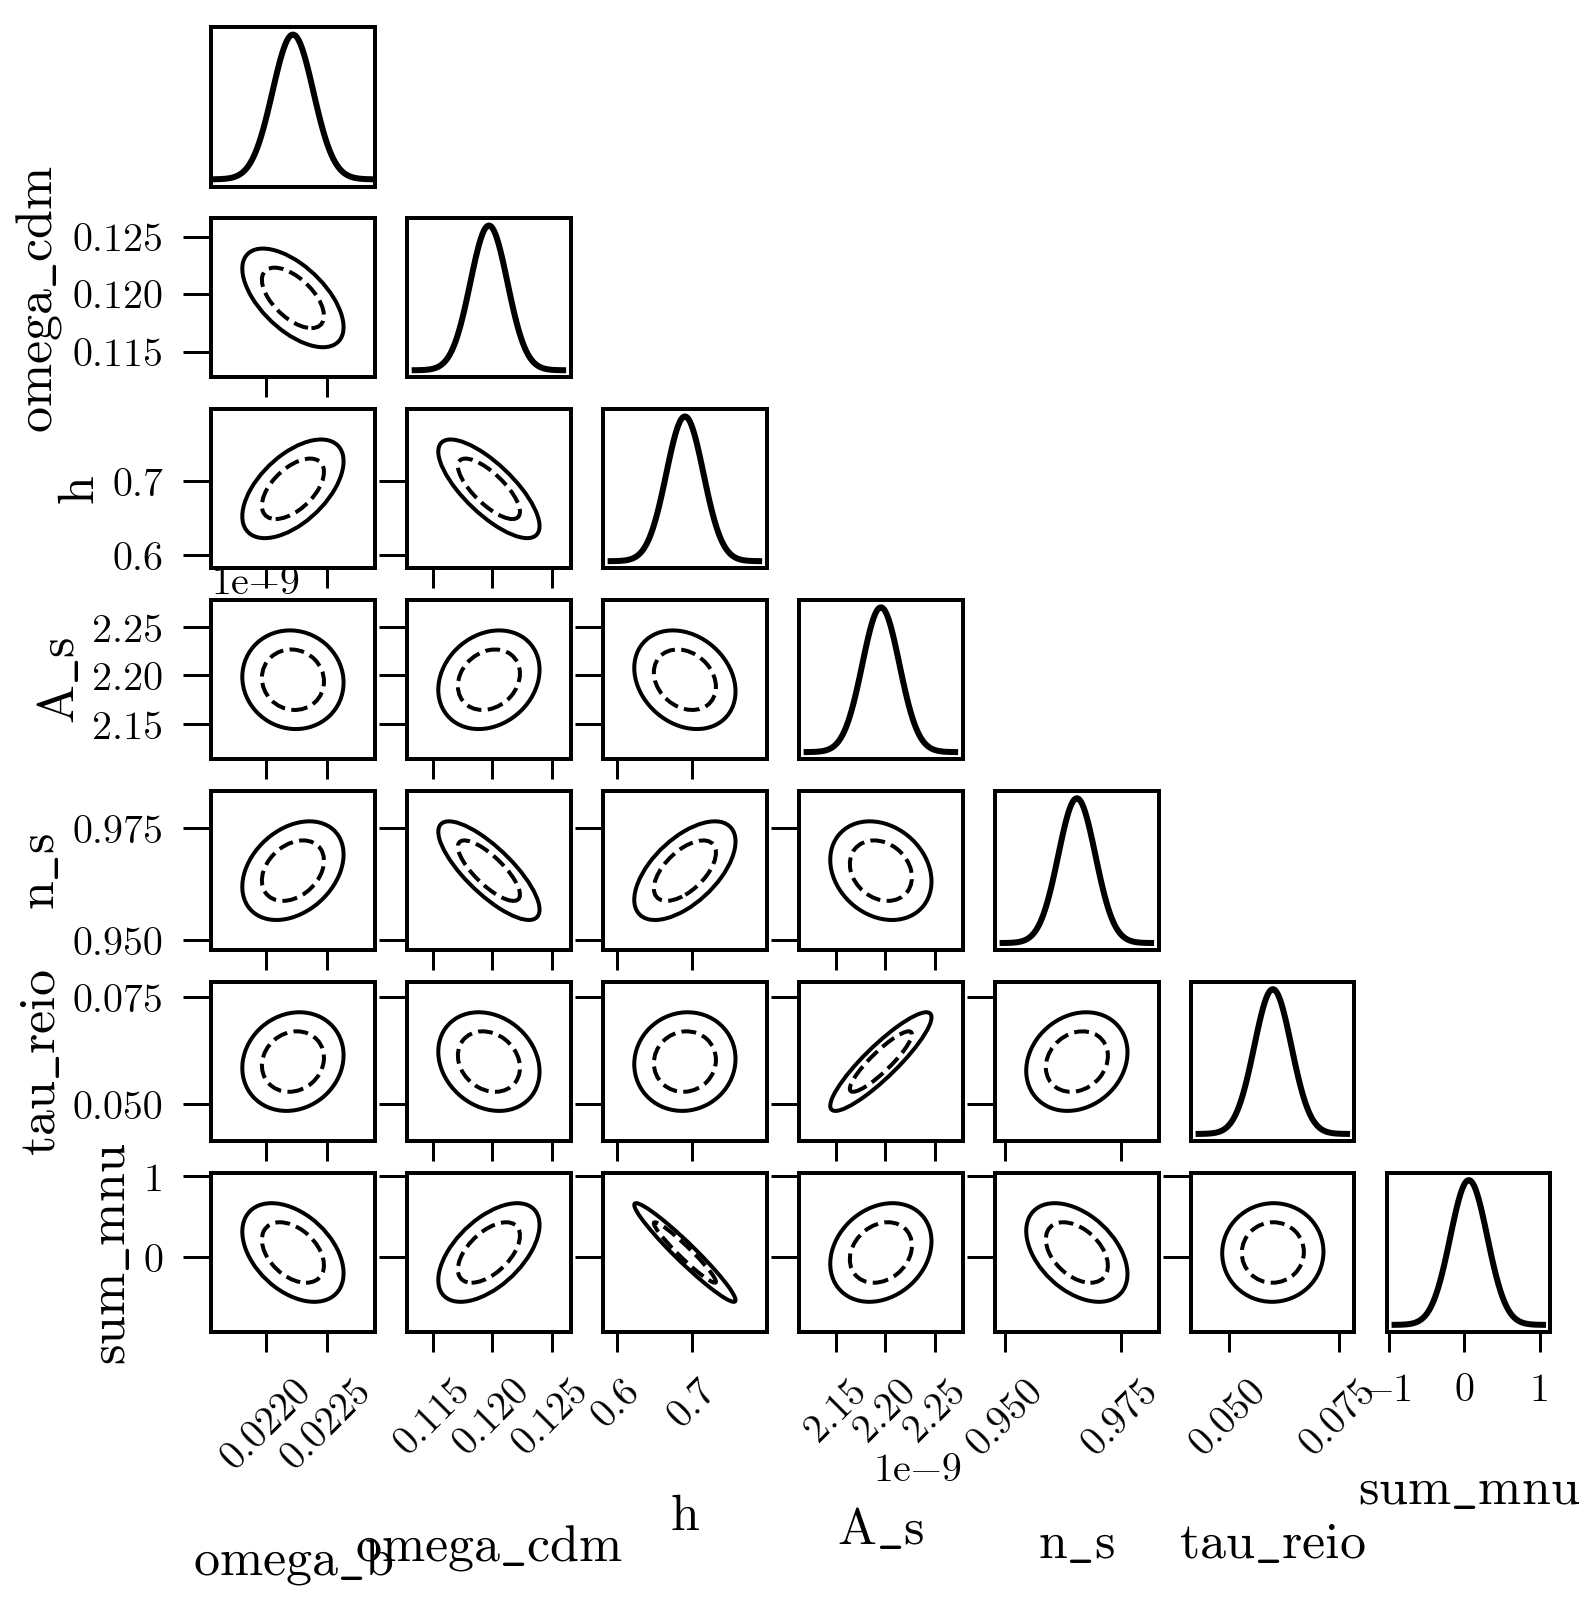

In [18]:

# CMB + lensing
fisher = np.sum( [exp.get_fisher(obs, lensed_Cl=True) for exp in Allison_Planck], axis=0 )
cov = np.linalg.inv(fisher)
fishchips.util.plot_triangle(obs, cov);

In [20]:
np.sqrt( cov[-1,-1] )

0.2457044960407301

In [21]:
cov

array([[ 2.82337621e-08, -1.72318459e-07,  2.51598517e-06,
        -2.03364094e-16,  2.42246907e-07,  1.00329759e-07,
        -1.74340335e-05],
       [-1.72318459e-07,  2.98825208e-06, -3.51205179e-05,
         7.24076581e-15, -6.02547512e-06, -1.62213696e-06,
         2.37600788e-04],
       [ 2.51598517e-06, -3.51205179e-05,  7.23275116e-04,
        -1.32029796e-13,  7.01296700e-05,  6.78608473e-06,
        -6.36539906e-03],
       [-2.03364094e-16,  7.24076581e-15, -1.32029796e-13,
         4.26335877e-22, -2.01033415e-14,  8.60596190e-14,
         1.16070417e-12],
       [ 2.42246907e-07, -6.02547512e-06,  7.01296700e-05,
        -2.01033415e-14,  1.95145248e-05,  3.83236813e-06,
        -4.74937678e-04],
       [ 1.00329759e-07, -1.62213696e-06,  6.78608473e-06,
         8.60596190e-14,  3.83236813e-06,  2.15972966e-05,
         1.69283398e-05],
       [-1.74340335e-05,  2.37600788e-04, -6.36539906e-03,
         1.16070417e-12, -4.74937678e-04,  1.69283398e-05,
         6.0370699